In [2]:
import pandas as pd 
import numpy as np
from time import time
import seaborn as sns

In [3]:
import scikitplot as skplt

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn import preprocessing

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
from matplotlib import pyplot

import sys
import warnings
warnings.filterwarnings("ignore")

## Dataset

In this section we import our dataset (already processed and encoded) and check for correlated variables

The features we are interested in have to be as independent as possible from each other. Therefore, we are going to
make sure that we don't have any correlated columns with a value higher than .95

In [26]:
dataset_original = pd.read_csv(r'..\reports\provisional.csv', index_col = 0)
dataset_original = dataset_original.dropna()
dataset = dataset_original.copy()

In [27]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

categorical_variables = ["season", "team", "Away_team", "result"]

for col in categorical_variables:
    dataset[f"{col}_encoded"] = le.fit_transform(dataset[col])

In [28]:
dataset = dataset.drop(['season','team','Away_team','result','index_match','GD_away'], axis=1)
dataset

,division,matchday,W,L,T,rank,GD_home,season_encoded,team_encoded,Away_team_encoded,result_encoded
9,1,2,1.0,0.0,0.0,1.0,5.0,0,110,23,2
7,1,2,1.0,0.0,0.0,3.0,1.0,0,68,11,0
8,1,2,0.0,1.0,0.0,9.0,-2.0,0,103,115,0
5,1,2,0.0,1.0,0.0,7.0,-1.0,0,7,56,0
6,1,2,1.0,0.0,0.0,4.0,1.0,0,12,65,0
...,...,...,...,...,...,...,...,...,...,...,...
47993,2,3,1.0,0.0,1.0,7.0,2.0,90,75,96,0
47997,2,3,2.0,0.0,0.0,2.0,3.0,90,136,120,0
47994,2,3,1.0,0.0,1.0,4.0,2.0,90,117,36,2
47992,2,3,1.0,1.0,0.0,10.0,1.0,90,49,114,1


In [29]:
cor_matrix = dataset.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))

to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
print(); print(to_drop)  



[]


<AxesSubplot:>

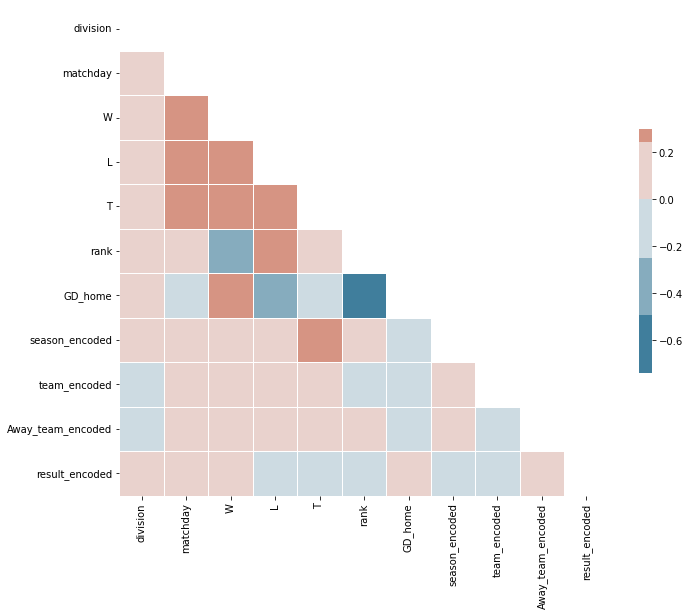

In [30]:
# Compute the correlation matrix
corr = dataset.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=False)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Automatic Variable Selection
In order to have an automatic variable selection we can use a **model-based** feature selection. Consequently, we will use a supervised machine learning model to judge the importance of each feature.

We will add some noise feature to our data and expect that the feature selection will identify the features that are non informative, removing the data features that are irrelevant.

For that purpose, we will add as many noise features as we have and select the 50% that are more correlated. Then, we will discard the noise features. The variables selected can be shown belove: black are original features and white noise features

X_train.shape: (36180, 5)
y_train.shape: (36180,)
X_train_l1.shape: (36180, 5)


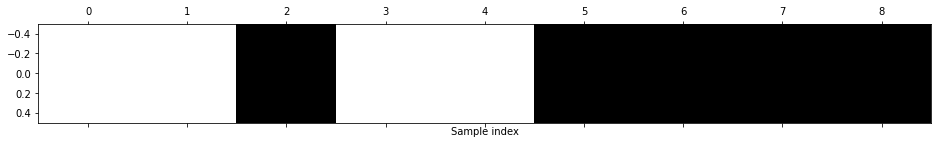

In [36]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

dataset = dataset.dropna()
target = dataset.result_encoded
X = dataset[['division','matchday','season_encoded','home_team_encoded','away_team_encoded']]
#target = dataset.result
#X = dataset.loc[:, dataset.columns != 'result']

# get deterministic random numbers
rng = np.random.RandomState(42)
noise = rng.normal(size=(len(dataset), 4))
X_w_noise = np.hstack([X, noise])

X_train,X_test,y_train,y_test = train_test_split(X_w_noise, target, test_size=0.25)

select = SelectFromModel( RandomForestClassifier(n_estimators=100, random_state=42), threshold="median")

select.fit(X_train, y_train)
X_train = select.transform(X_train)
print("X_train.shape: {}".format(X_train.shape))
print("y_train.shape: {}".format(y_train.shape))

print("X_train_l1.shape: {}".format(X_train.shape))

mask = select.get_support()
# visualize the mask -- black is True, white is False
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Sample index")

X_test = select.transform(X_test)

## Normal selection of variables and splitting data

In [31]:
dataset = dataset.dropna()
target = dataset.result_encoded
X = dataset.loc[:, dataset.columns != 'result_encoded']
#X = dataset[['season','division','matchday','team','Away_team','W','GD_cum_before','rank_before']]
X_train,X_test,y_train,y_test = train_test_split(X, target, test_size=0.2, random_state=1, stratify=target)

## Function to construct confusion matrix and ROC

In [32]:
#plot our results
def confusion_matrix(trained_model, y_test, X_test):
    Y_test_pred = trained_model.predict(X_test)

    fig = plt.figure(figsize=(15,6))
    ax1 = fig.add_subplot(121)
    skplt.metrics.plot_confusion_matrix(y_test, Y_test_pred,
                                        title="Confusion Matrix",
                                        cmap="Oranges",
                                        ax=ax1)

    ax2 = fig.add_subplot(122)
    skplt.metrics.plot_confusion_matrix(y_test, Y_test_pred,
                                        normalize=True,
                                        title="Confusion Matrix",
                                        cmap="Purples",
                                        ax=ax2)

def ROC_PRC_matrix(trained_model, y_test, X_test):    
    y_test_probs = trained_model.predict_proba(X_test)
    
    fig = plt.figure(figsize=(15,6))
    ax1 = fig.add_subplot(121)
    skplt.metrics.plot_roc_curve(y_test, y_test_probs,
                       title="Digits ROC Curve", figsize=(12,6), ax=ax1)
    
    ax2 = fig.add_subplot(122)
    skplt.metrics.plot_precision_recall_curve(y_test, y_test_probs,
                        title="Digits Precision-Recall Curve", figsize=(12,6), ax= ax2)

## Estimations of parameters in models

In [37]:
# Looking for best parameter for logistic regression model
for C in [0.001, 0.01, 0.1, 1, 10, 100]:
    logreg = LogisticRegression(C=C).fit(X_train, y_train)
    prediction_in = logreg.predict(X_train)
    accuracy_r2_in = r2_score(y_train, prediction_in)
    prediction_out = logreg.predict(X_test)
    accuracy_r2_out = r2_score(y_test, prediction_out)
    print() 
    print("Logistic Regression with parameter ", C) 
    print("-" * 20)
    print("Accuracy on training set: ",logreg.score(X_train, y_train), "\tR2 training set: ", accuracy_r2_in )
    print("Accuracy on test set: ",logreg.score(X_test, y_test), "\tR2 test set: ", accuracy_r2_out )



Logistic Regression with parameter  0.001
--------------------
Accuracy on training set:  0.41304582210242585 	R2 training set:  -1.099616017610491
Accuracy on test set:  0.4126778783958603 	R2 test set:  -1.097391435425779

Logistic Regression with parameter  0.01
--------------------
Accuracy on training set:  0.41336927223719677 	R2 training set:  -1.089940701742591
Accuracy on test set:  0.4154808106942648 	R2 test set:  -1.0753624485418154

Logistic Regression with parameter  0.1
--------------------
Accuracy on training set:  0.41285714285714287 	R2 training set:  -1.0986738520203585
Accuracy on test set:  0.4153730056058646 	R2 test set:  -1.082463898260988

Logistic Regression with parameter  1
--------------------
Accuracy on training set:  0.41342318059299193 	R2 training set:  -1.1001958118198036
Accuracy on test set:  0.4153730056058646 	R2 test set:  -1.0828986808968555

Logistic Regression with parameter  10
--------------------
Accuracy on training set:  0.4123180592991

In [31]:
# Preprunning for decision tree model, avoiding overfitting
for depth in range(3,8):
    tree = DecisionTreeClassifier(max_depth=depth).fit(X_train, y_train)
    prediction_in = tree.predict(X_train)
    accuracy_r2_in = r2_score(y_train, prediction_in)
    prediction_out = tree.predict(X_test)
    accuracy_r2_out = r2_score(y_test, prediction_out)
    print() 
    print("Decision tree with depth ", depth) 
    print("-" * 20)
    print("Accuracy on training set: ",tree.score(X_train, y_train), "\tR2 training set: ", accuracy_r2_in )
    print("Accuracy on test set: ",tree.score(X_test, y_test), "\tR2 test set: ", accuracy_r2_out )



Decision tree with depth  3
--------------------
Accuracy on training set:  0.527285447761194 	R2 training set:  -0.7482987197355464
Accuracy on test set:  0.5298507462686567 	R2 test set:  -0.7412019491066593

Decision tree with depth  4
--------------------
Accuracy on training set:  0.5299803067993366 	R2 training set:  -0.7073791484896221
Accuracy on test set:  0.5280887230514096 	R2 test set:  -0.7081531844725697

Decision tree with depth  5
--------------------
Accuracy on training set:  0.5309131426202321 	R2 training set:  -0.7291712841130091
Accuracy on test set:  0.5296434494195689 	R2 test set:  -0.7292108044164145

Decision tree with depth  6
--------------------
Accuracy on training set:  0.533271144278607 	R2 training set:  -0.7093137936957186
Accuracy on test set:  0.5303689883913765 	R2 test set:  -0.7167809593106726

Decision tree with depth  7
--------------------
Accuracy on training set:  0.5360955638474295 	R2 training set:  -0.6926320416356049
Accuracy on test se

In [32]:
# Random forest model

# We set max_depth = 5 as preprunning parameter
# We set max_features as sqrt of n_features to reduce overfitting (pag 102)

for trees in range(5,10):
    for depth in range(2,6):
        random_forest = RandomForestClassifier(max_depth=depth, n_estimators=trees, max_features=3).fit(X_train, y_train)
        prediction_in = random_forest.predict(X_train)
        accuracy_r2_in = r2_score(y_train, prediction_in)
        prediction_out = random_forest.predict(X_test)
        accuracy_r2_out = r2_score(y_test, prediction_out)
        print() 
        print(f"Random_forest with {trees} trees and {depth} depth") 
        print("-" * 40)
        print("Accuracy on training set: ",random_forest.score(X_train, y_train), "\tR2 training set: ", accuracy_r2_in )
        print("Accuracy on test set: ",random_forest.score(X_test, y_test), "\tR2 test set: ", accuracy_r2_out )



Random_forest with 5 trees and 2 depth
----------------------------------------
Accuracy on training set:  0.527285447761194 	R2 training set:  -0.7482987197355464
Accuracy on test set:  0.5298507462686567 	R2 test set:  -0.7412019491066593

Random_forest with 5 trees and 3 depth
----------------------------------------
Accuracy on training set:  0.527285447761194 	R2 training set:  -0.7482987197355464
Accuracy on test set:  0.5298507462686567 	R2 test set:  -0.7412019491066593

Random_forest with 5 trees and 4 depth
----------------------------------------
Accuracy on training set:  0.531224087893864 	R2 training set:  -0.7284047265785181
Accuracy on test set:  0.533271144278607 	R2 test set:  -0.7197056287473178

Random_forest with 5 trees and 5 depth
----------------------------------------
Accuracy on training set:  0.5308872305140961 	R2 training set:  -0.7357782800055268
Accuracy on test set:  0.5322346600331676 	R2 test set:  -0.7290645709445822

Random_forest with 6 trees and 


Logistic Regression
--------------------
Accuracy on training set:  0.4138544474393531
Accuracy on test set:  0.4166666666666667

Decision Tree
--------------------
Accuracy on training set:  0.41088948787061996
Accuracy on test set:  0.4101983613626563

Random Forest
--------------------
Accuracy on training set:  0.4203234501347709
Accuracy on test set:  0.4207632600258732


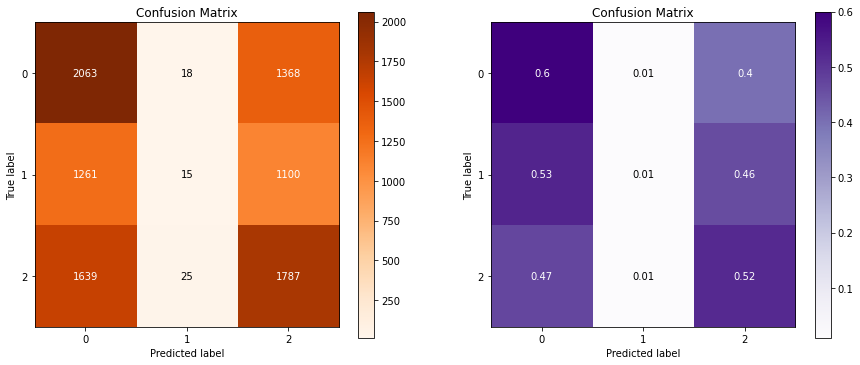

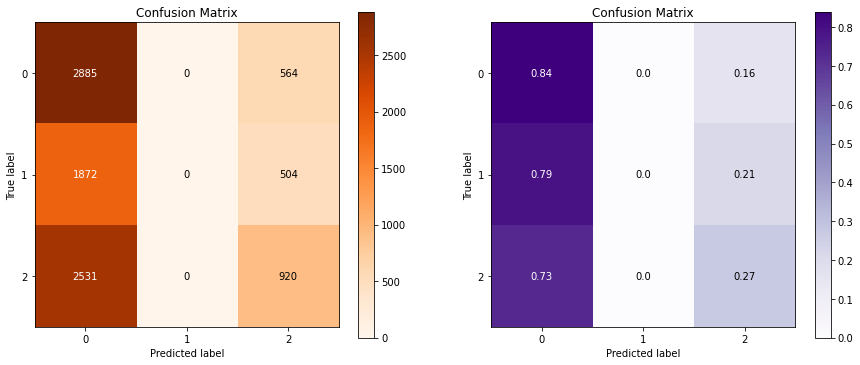

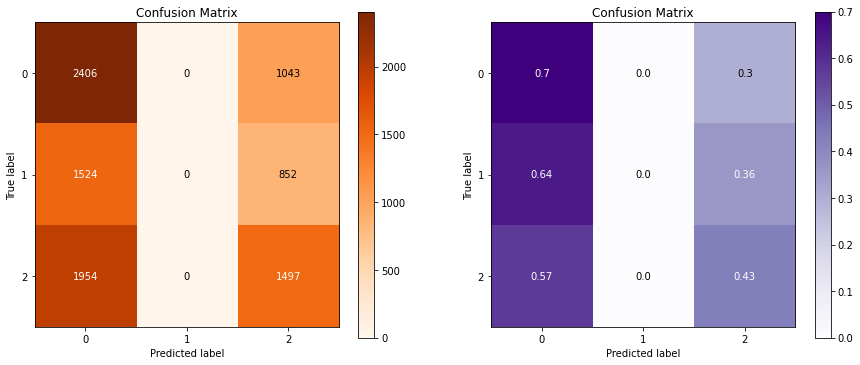

In [41]:
names = ["Logistic Regression", "Decision Tree", "Random Forest"]
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier

classifiers = [
    #KNeighborsClassifier(3),
    LogisticRegression(solver='sag', multi_class='auto', max_iter=1000),
    DecisionTreeClassifier(max_depth=1),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
]


for name, clf in zip(names, classifiers):
        model = OneVsOneClassifier(clf).fit(X_train, y_train)
        prediction_in = model.predict(X_train)
        accuracy_r2_in = r2_score(y_train, prediction_in)
        prediction_out = model.predict(X_test)
        accuracy_r2_out = r2_score(y_test, prediction_out)
        print() 
        print(name) 
        print("-" * 20)
        print("Accuracy on training set: ",model.score(X_train, y_train))
        print("Accuracy on test set: ",model.score(X_test, y_test))
        #ROC_PRC_matrix(model, y_test, X_test)
        confusion_matrix(model, y_test, X_test)


## De encoding 


In [38]:
result_in = le.inverse_transform(prediction_in).tolist()
result_out = le.inverse_transform(prediction_out).tolist()
result = result_in + result_out

In [39]:
dataset_original['Predictions'] = result

In [40]:
dataset_original

,season,division,matchday,team,Away_team,index_match,W,L,T,result,rank,GD_home,GD_away,Predictions
9,1928-1929,1,2,Real Madrid,Barcelona,5,1.0,0.0,0.0,W,1.0,5.0,-5.0,W
7,1928-1929,1,2,Espanyol,Athletic,6,1.0,0.0,0.0,L,3.0,1.0,-1.0,L
8,1928-1929,1,2,Racing,Real Unión,8,0.0,1.0,0.0,L,9.0,-2.0,2.0,W
5,1928-1929,1,2,Arenas Club,Catalunya,9,0.0,1.0,0.0,L,7.0,-1.0,1.0,L
6,1928-1929,1,2,Athletic Madrid,Donostia,7,1.0,0.0,0.0,L,4.0,1.0,-1.0,L
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47993,2021-2022,2,3,Girona,Ponferradina,48235,1.0,0.0,1.0,L,7.0,2.0,-2.0,L
47997,2021-2022,2,3,UD Almería,SD Amorebieta,48236,2.0,0.0,0.0,L,2.0,3.0,-3.0,W
47994,2021-2022,2,3,Real Valladolid,CD Lugo,48237,1.0,0.0,1.0,W,4.0,2.0,-2.0,L
47992,2021-2022,2,3,CF Fuenlabrada,Real Sociedad B,48238,1.0,1.0,0.0,T,10.0,1.0,-1.0,W
